Install Dependencies

In [1]:
!pip install scikit-image matplotlib scikit-learn joblib


Import Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import regionprops
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import joblib


In [3]:
from google.colab import files
uploaded = files.upload()

# Rename your image to 'car.jpg' or access by filename directly


Saving car.jpeg to car (1).jpeg


**License Plate Detection (Plate localization)**

This is the first stage and at the end of this stage, we should be able to identify the license plate’s position on the car. In order to do this, we need to read the image and convert it to grayscale. In a grayscale image, each pixel is between 0 & 255. We now need to convert it to a binary image in which a pixel is either complete black or white.

Localizaton

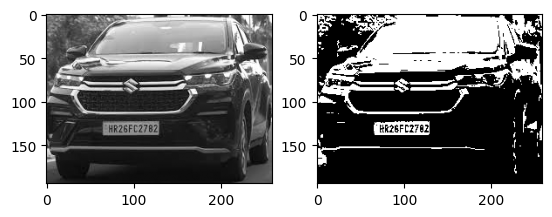

In [4]:
car_image = imread("car.jpeg", as_gray=True)
gray_car_image = car_image * 255
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
ax2.imshow(binary_car_image, cmap="gray")
plt.show()


Connected Component Analysis

We need to identify all the connected regions in the image, using connected component analysis (CCA). Other approaches like edge detection and morphological processing can also be explored. CCA basically helps in group and label connecting regions on the foreground. A pixel is deemed to be connected to another if they both have the same value and are adjacent to each other.

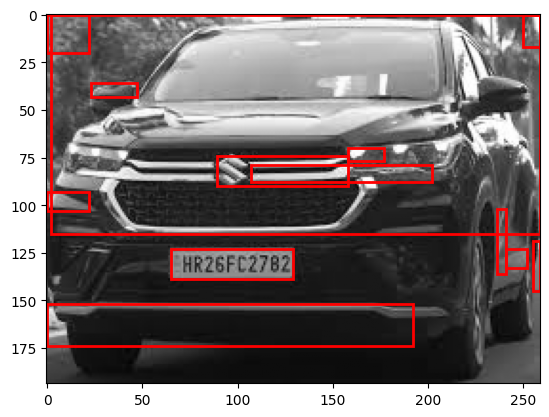

In [5]:
label_image = measure.label(binary_car_image)
fig, ax1 = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray")

for region in regionprops(label_image):
    if region.area < 50:
        continue
    min_row, min_col, max_row, max_col = region.bbox
    rect = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rect)

plt.show()


Filter Plate Like Regions

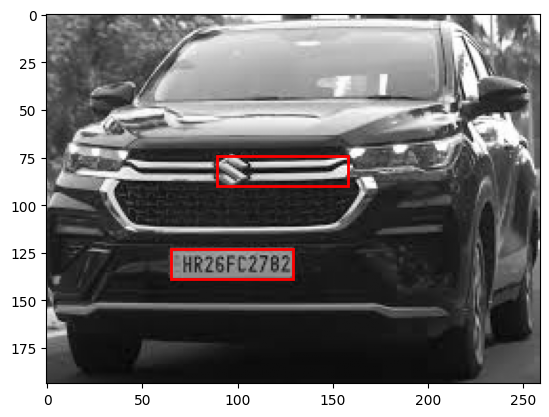

In [8]:
plate_dimensions = (0.08 * label_image.shape[0], 0.2 * label_image.shape[0], 0.15 * label_image.shape[1], 0.4 * label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions
plate_like_objects = []
plate_coords = []

fig, ax1 = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray")

for region in regionprops(label_image):
    if region.area <50:
        continue
    min_row, min_col, max_row, max_col = region.bbox
    height = max_row - min_row
    width = max_col - min_col

    if height >= min_height and height <= max_height and width >= min_width and width <= max_width and width > height:
        plate_like_objects.append(binary_car_image[min_row:max_row, min_col:max_col])
        plate_coords.append((min_row, min_col, max_row, max_col))
        rect = patches.Rectangle((min_col, min_row), width, height, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rect)

plt.show()


 The **measure.label** method was used to map all the connected regions in the binary image and label them. Calling the **regionprops** method on the labelled image will return a list of all the regions as well as their properties like area, bounding box, label etc. We used the **patches.Rectangle** method to draw a rectangle over all the mapped regions.

check how many regions were actually detected and only access if it exists

Number of plate-like regions detected: 2


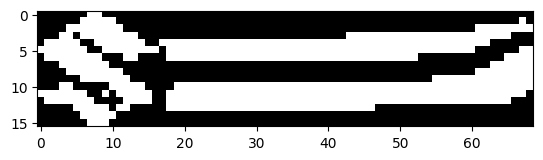

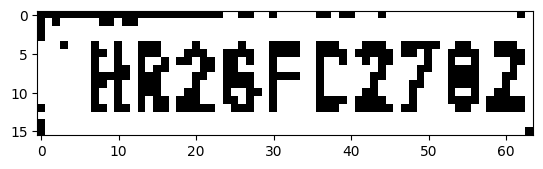

In [21]:
# Check how many plate-like objects were detected
print(f"Number of plate-like regions detected: {len(plate_like_objects)}")

# Safely access the desired region only if it exists
if len(plate_like_objects) > 0:
  for i in range(len(plate_like_objects)):
    plt.imshow(plate_like_objects[i], cmap="gray")
    plt.show()
    continue

    license_plate = np.invert(plate_like_objects[1])  # use index 0 safely
    labelled_plate = measure.label(license_plate)

    fig, ax1 = plt.subplots(1)
    ax1.imshow(license_plate, cmap="gray")
    ax1.set_title("Detected License Plate")
    plt.show()
else:
    print("No plate-like regions were detected.")

# o index we have first detected object and 1 index we have our desired number plate

Segment Characters From Plate

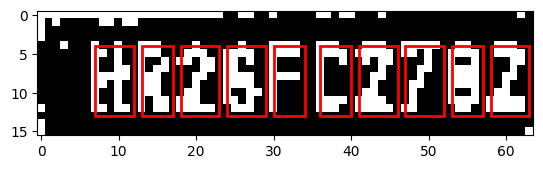

Number of segmented characters: 10
Number of Column_list: 10
7
13
18
24
30
36
41
47
53
58


In [39]:
license_plate = np.invert(plate_like_objects[1])  # Use index 2 by default
labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

char_dims = (0.35 * license_plate.shape[0], 0.6 * license_plate.shape[0], 0.05 * license_plate.shape[1], 0.15 * license_plate.shape[1])
min_h, max_h, min_w, max_w = char_dims

characters = []
column_list = []

for region in regionprops(labelled_plate):
    y0, x0, y1, x1 = region.bbox
    h, w = y1 - y0, x1 - x0
    if h > min_h and h < max_h and w > min_w and w < max_w:
        roi = license_plate[y0:y1, x0:x1]
        resized = resize(roi, (20, 20)) #resize the characters to 20X20 and then append each character into the characters list
        characters.append(resized)
        column_list.append(x0) # this is just to keep track of the arrangement of the characters
        ax1.add_patch(patches.Rectangle((x0, y0), w, h, edgecolor="red", linewidth=2, fill=False))

plt.show()
print("Number of segmented characters:", len(characters))
print("Number of Column_list:", len(column_list))

#for i in range(len(characters)):
#    plt.imshow(characters[i], cmap="gray")
#    plt.show()
#    continue

for i in range(len(column_list)):
    print(column_list[i])


Train the SVM Model

In [55]:
pip install scikit-learn


generated small dataset for training

In [62]:
from PIL import Image, ImageDraw, ImageFont
import os

chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

# Use default font (works in Colab)
font = ImageFont.load_default()

# Create training folders
os.makedirs("train", exist_ok=True)

for c in chars:
    folder = f"train/{c}"
    os.makedirs(folder, exist_ok=True)
    for i in range(10):
        img = Image.new('L', (20, 20), color=255)  # white background
        draw = ImageDraw.Draw(img)
        draw.text((2, 2), c, fill=0, font=font)    # black text
        img.save(f"{folder}/{c}_{i}.jpg")

print("Dataset generated in `/content/train` folder.")



Dataset generated in `/content/train` folder.


In [64]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu

letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]

def read_training_data(training_directory):
    image_data = []
    target_data = []
    for each_letter in letters:
        for each in range(10):
            image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
            # read each image of each character
            img_details = imread(image_path, as_gray=True)
            # converts each character image to binary image
            binary_image = img_details < threshold_otsu(img_details)
            # the 2D array of each image is flattened because the machine learning
            # classifier requires that each sample is a 1D array
            # therefore the 20*20 image becomes 1*400
            # in machine learning terms that's 400 features with each pixel
            # representing a feature
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(each_letter)

    return (np.array(image_data), np.array(target_data))

def cross_validation(model, num_of_fold, train_data, train_label):
    # this uses the concept of cross validation to measure the accuracy
    # of a model, the num_of_fold determines the type of validation
    # e.g if num_of_fold is 4, then we are performing a 4-fold cross validation
    # it will divide the dataset into 4 and use 1/4 of it for testing
    # and the remaining 3/4 for the training
    accuracy_result = cross_val_score(model, train_data, train_label, cv=num_of_fold)
    print("Cross Validation Result for ", str(num_of_fold), " -fold")

    print(accuracy_result * 100)


# Use absolute path to your training data folder
training_dataset_dir = '/content/train'


image_data, target_data = read_training_data(training_dataset_dir)

# the kernel can be 'linear', 'poly' or 'rbf'
# the probability was set to True so as to show
# how sure the model is of it's prediction
svc_model = SVC(kernel='linear', probability=True)

cross_validation(svc_model, 4, image_data, target_data)

# let's train the model with all the input data
svc_model.fit(image_data, target_data)

# we will use the joblib module to persist the model
# into files. This means that the next time we need to
# predict, we don't need to train the model again
save_directory = '/content/train/models/svc'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
joblib.dump(svc_model, save_directory+'/svc.pkl')

Cross Validation Result for  4  -fold
[100. 100. 100. 100.]


['/content/train/models/svc/svc.pkl']

Predict Characters

In [67]:
model = joblib.load("/content/train/models/svc/svc.pkl")

classification_result = []

for char_img in characters:
    prediction = model.predict(char_img.reshape(1, -1))
    classification_result.append(prediction)

# Sort characters based on X-axis (left to right)
column_list_copy = column_list[:]
column_list.sort()
final_plate = ''

for col in column_list:
    final_plate += classification_result[column_list_copy.index(col)][0]

print("Predicted License Plate:", final_plate)


Predicted License Plate: L57W5LTQ5J
